## <code>LPGerchbergSaxton_SLM_3spots.ipynb </code> 
## Computer generated hologram using Gerchberg-Saxton algorithm
- Keller-D9 >> environment: lightpipes
 
#### Adapted to Python 3.7 by Raghav K. Chhetri (May 2021) from the following MATLAB scripts 
    - Original by Dr F.A. van Goor, University of Twente (April 2010)
    - Reorganized by Adam Packer (December 2013) -> SLMPhaesMaskMaker_LightPipes.m
    
My MATLAB script <code>D:/Dropbox (Personal)/slm.rc__Convert-to-Python/LPGerchbergSaxton_RC_SLM1920_v3_beta.m</code>

In [1]:
from LightPipes import *
import numpy as np
import matplotlib
%matplotlib inline
import pylab as plt
from skimage import io
from os.path import join
import time
import sys

Version of packages used in this notebook:

In [2]:
print('Python version', sys.version)
print('Numpy', np.__version__)
print('Matplotlib', matplotlib.__version__)
print('LightPipes', LPversion)
LPtest()

Python version 3.7.7 (default, May  6 2020, 11:45:54) [MSC v.1916 64 bit (AMD64)]
Numpy 1.18.1
Matplotlib 3.1.3
LightPipes 2.0.5
Test OK


In [3]:
wavelength =488*nm
dxdz  = 70*um; #dx and dz of spots in the sample plane
MagAM = 6; #Magnification from sample to Apodizing Mask
dXdZ = MagAM*dxdz; #dX and dZ of spots at the Apodizing Mask

fSLM = 750*mm
SLMpixel = 9.2*um
SLMheight = 1920
SLMwidth = 1152
gridsize = np.ceil((fSLM*wavelength/SLMpixel)/dXdZ)*dXdZ

#Choose Nunits 'Number of grid-units per dXdZ' such that gridpixels > SLMheight
Nunits = 70; #even; For 488, 30 and up; For 561/631, 20 and up; [20,30,60,70,140,210]
unit = dXdZ/Nunits
gridpixels = int(gridsize/unit)

#Optic axis co-ordinate(zero-order beam)
Oaxis = gridsize/2
#Define the position of the center beam in the 3x3 array
X = Oaxis + dXdZ/2
Z = Oaxis + dXdZ/2

#Beam diameter on the SLM (1/e diameter); Recall that 1/e_width = 1.2 x FWHM_width
beamD = 1.2*9*mm

Field= Begin(gridsize, wavelength, gridpixels) #Plane wave distribution with amplitude 1 and phase 0
#Field= GaussAperture(Field, w = beamD/2, x_shift=0.0, y_shift=0.0, T=1.0) #An aperture with a Gaussian shape
Field= GaussBeam(Field, beamD/2)

"""
#To insert cylindrical lens pair
f1 = 150*mm
angle1 = 0.0*deg
f2 = 50*mm
angle2 = 0.0*deg
Field = CylindricalLens(Field,f1,angle=angle1) # cylindrical lens f1
Field = Forvard(Field,f1+f2) # propagate f1+f2
Field = CylindricalLens(Field,f2,angle=angle2) # cylindrical lens f2
Field = Forvard(Field,3*(f1+f2)) # propagate 3*(f1+f2)
"""
SLMfield = RectAperture(Field, sx=SLMheight*SLMpixel, sy=SLMwidth*SLMpixel, x_shift=0.0, y_shift=0.0, angle=0.0)
print(type(SLMfield.field), SLMfield.field.dtype, SLMfield.field.shape)

<class 'numpy.ndarray'> complex128 (6650, 6650)


In [4]:
print('Pixels in the grid:', gridpixels)
print('Pixels along SLM height:',SLMheight)
print('OK to proceed') if gridpixels > SLMheight else print('Increase "Nunits" such that "gridpixels" > "SLMheight"')

Pixels in the grid: 6650
Pixels along SLM height: 1920
OK to proceed


In [5]:
# Define beam-spot positions in the target grid
"""
spots_X = np.array([X, X-dXdZ, X+dXdZ,
    X-4*dXdZ, (X-4*dXdZ)-dXdZ, (X-4*dXdZ)+dXdZ,
    X+4*dXdZ, (X+4*dXdZ)-dXdZ, (X+4*dXdZ)+dXdZ])/unit

spots_Z = np.array([Z, Z-dXdZ, Z+dXdZ,
    Z, Z-dXdZ, Z+dXdZ,
    Z, Z-dXdZ, Z+dXdZ])/unit

# MID
spots_X = np.array([X, X-4*dXdZ, X+4*dXdZ])/unit
spots_Z = np.array([Z, Z, Z])/unit

# FAR
spots_X = np.array([X-dXdZ, (X-4*dXdZ)-dXdZ, (X+4*dXdZ)-dXdZ])/unit
spots_Z = np.array([Z-dXdZ, Z-dXdZ, Z-dXdZ])/unit

# NEAR
spots_X = np.array([X+dXdZ, (X-4*dXdZ)+dXdZ, (X+4*dXdZ)+dXdZ])/unit
spots_Z = np.array([Z+dXdZ, Z+dXdZ, Z+dXdZ])/unit
"""
# NEAR
spots_X = np.array([X+dXdZ, (X-4*dXdZ)+dXdZ, (X+4*dXdZ)+dXdZ])/unit
spots_Z = np.array([Z+dXdZ, Z+dXdZ, Z+dXdZ])/unit

spots_X = spots_X.astype(int)
spots_Z = spots_Z.astype(int)

# To flip the orientation of the spots
# spots_Xf = spots_Z;
# spots_Zf = spots_X;

target = np.zeros((gridpixels, gridpixels)) #Note: LightPipes command 'SubIntensity' needs floats
for j in range(len(spots_X)):
    target[spots_X[j],spots_Z[j]] = 255
print(type(target), target.shape, np.min(target), np.max(target), target.dtype)

<class 'numpy.ndarray'> (6650, 6650) 0.0 255.0 float64


In [6]:
print(len(spots_X))
print(spots_X, spots_Z)
print(target[spots_X[0], spots_X[0]], target[spots_X[1], spots_Z[1]], target[spots_X[2], spots_Z[2]])


3
[3430 3150 3710] [3430 3430 3430]
255.0 255.0 255.0


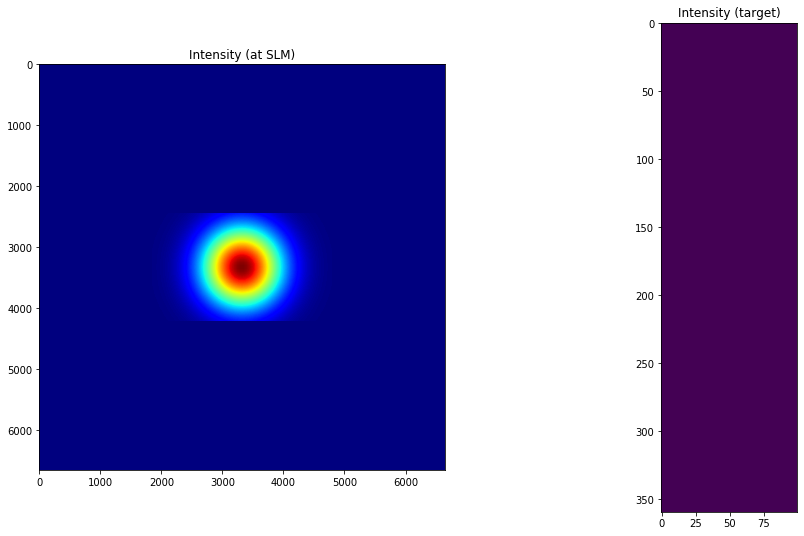

In [7]:
ISLM = Intensity(SLMfield)

#Plots
"""
top= len(target)//2 - 150
bottom= len(target)//2 + 180
left= len(target)//2 -50
right= len(target)//2 + 80
""" 
top= len(target)//2 - 180
bottom= len(target)//2 + 180
left= len(target)//2 -20
right= len(target)//2 + 80

plt.figure(figsize=(16,9))
plt.subplot(1,2,1)
plt.title('Intensity (at SLM)')
plt.imshow(ISLM,cmap='jet')
plt.subplot(1,2,2)
plt.title('Intensity (target)')
plt.imshow(target[top:bottom,left:right])

In [8]:
# Iteration loop to get phase distribution
Niter = 12 
Field = SLMfield
UniformIntensity = np.ones((gridpixels, gridpixels)) #Matrix filled with 1's to substitute a uniform intensity profile

t0 = time.time()
for i in range(Niter):    
    #print(i)  
#2-D Fourier transform of the field; Forward transform with index 1
    Field = PipFFT(Field, index = 1)     
#Substitute the original intensity distribution while leaving the phase unchanged
    Field = SubIntensity(Field, target)
#Inverse Fourier transform; Back transform with index -1
    Field = PipFFT(Field, index = -1) 
#Substitute a uniform intensity while leaving the phase unchanged
    Field = SubIntensity(Field, UniformIntensity)
print('Took', round(time.time()-t0,2), 'sec')

Took 265.58 sec


<class 'numpy.ndarray'> (6650, 6650) float64
<class 'numpy.ndarray'> (1152, 1920) uint8


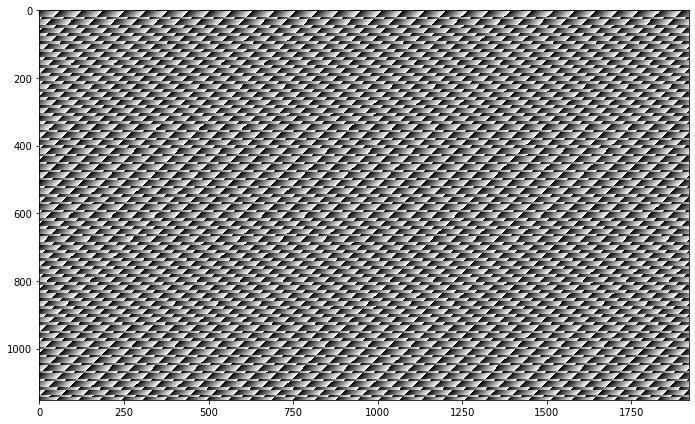

Took 1.79 sec


In [9]:
t0 = time.time()
#Extract the phase distribution from the field
Phaze = Phase(Field) 
PhaseZeroed = Phaze + np.abs(np.min(Phaze))

# Convert to 8-bit
Phase8 = PhaseZeroed*(255/np.max(PhaseZeroed))
print(type(Phase8), Phase8.shape, Phase8.dtype)
phaseMask8 = Phase8[0:SLMwidth,0:SLMheight].astype('uint8')
print(type(phaseMask8), phaseMask8.shape, phaseMask8.dtype)

fig = plt.figure(figsize=(10,6))
#plt.imshow(phaseMask8,cmap='gray')
#plt.show()
io.imshow(phaseMask8); io.show()
print('Took', round(time.time()-t0,2), 'sec')

In [10]:
outPath= 'D:/Desktop/img/'
outfilename= str(int(wavelength/nm))+ \
'nm_Points_Target.'+str(Nunits)+ \
'units.in.'+str(int(dXdZ/um))+ \
'um_Niter'+str(Niter)+'.bmp' 
#plt.imsave(join(outPath, outfilename), phaseMask8, cmap='gray') # Note that plt.imsave saves it as 32-bit instead of 8-bit
io.imsave(join(outPath, outfilename), phaseMask8)